In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle5 as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
import os
from random import shuffle
import matplotlib.pyplot as plt 

In [2]:
# import pathlib
# data_dir = pathlib.Path('E:/Users/sentinel_industry/downloaded_aois/')


In [3]:
np.double(2)

2.0

In [4]:
x_size = 230
y_size = 230
ch1_mean, ch1_std = 970.4162, 1051.8454
ch2_mean, ch2_std = 1176.249, 1031.262
ch3_mean, ch3_std = 1273.2376, 1117.068
ch4_mean, ch4_std = 2266.9050, 1241.5509
means = [ch1_mean,ch2_mean,ch3_mean,ch4_mean]
vari = [ch1_std, ch2_std, ch3_std, ch4_std]

def load_features(name):
    decoded = name.decode("UTF-8")
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            if (file["B02"].shape[1]<230 or file["B02"].shape[2]<230): 
                print("oh oh, downloaded patch too smol:", decoded)
            B02, B03, B04, B08 = file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]
            B02 = (B02-ch1_mean)/ch1_std
            B03 = (B03-ch2_mean)/ch2_std
            B04 = (B04-ch3_mean)/ch3_std
            B08 = (B08-ch4_mean)/ch4_std
            features = np.array([ B02, B03, B04, B08]).transpose(1,2,0)
            # features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)
        
def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.double, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

In [5]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [6]:
print(len(pkl_files))

2238


In [7]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [8]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [9]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [10]:
print(len(pkl_files_steel))

1707


In [11]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
shuffle(pkl_files)

In [12]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [13]:
print(len(pkl_files))

7966


In [14]:
dataset_len=len(pkl_files)

In [15]:


dataset_len=len(pkl_files)

train_size = int(np.floor(0.8 * dataset_len))
valid_size = int(np.floor(0.2 * dataset_len))
test_size = int(np.floor(0.0 * dataset_len))

train = tf.data.Dataset.from_tensor_slices(pkl_files[0:train_size]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)
valid = tf.data.Dataset.from_tensor_slices(pkl_files[train_size:train_size+valid_size]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)
test = tf.data.Dataset.from_tensor_slices(pkl_files[train_size+valid_size:]).map(data_loader,num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
tf.data.experimental.save(
    valid, 'savedata_valid')

tf.data.experimental.save(
    train, 'savedata_train')

In [24]:
valid = tf.data.experimental.load('savedata_valid')
train = tf.data.experimental.load('savedata_train')


In [38]:
train = train.shuffle(100,  reshuffle_each_iteration=True)

In [26]:
norm_data = train.take(valid_size).map(lambda x, y: x) #

In [22]:
# normalization_layer = tf.keras.layers.Normalization()
# normalization_layer.adapt(norm_data)

In [27]:
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_size,y_size,4)),
    # layers.RandomCrop(120,120, seed=in_seed, input_shape=(x_size,y_size,4)),
    layers.CenterCrop(120,120, ),
    # layers.Rescaling(1./10000),#,input_shape=(240,240,4)),
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed),
    # norm_layer
])

In [28]:
# dataset = dataset.map((
#   lambda x, y: (resize_and_rescale(x), y)))

In [29]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(230, 230, 4)
(3,)


In [322]:
train

<ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [30]:
model = tf.keras.Sequential([
    resize_rescale_augment,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3)
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])


In [31]:
model.build()

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 120, 120, 4)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 16)      592       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 64)       

In [33]:
# image_batch, labels_batch = next(iter(dataset))

In [34]:
# validation_inputs, validation_targets = next(iter(valid))

In [35]:
# next(iter(valid))

In [36]:
epochs=20
batch_size = 40
history = model.fit(
  train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
  validation_data=valid.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
    validation_steps=1,
  epochs=epochs,
)

Epoch 1/20
159/159 [==============================] - 98s 602ms/step - loss: 0.7240 - binary_accuracy: 0.7838 - val_loss: 0.5612 - val_binary_accuracy: 0.7917
Epoch 2/20
 45/159 [=======>......................] - ETA: 1:38 - loss: 0.5683 - binary_accuracy: 0.8228

KeyboardInterrupt: 

In [135]:
history.history

{'loss': [0.8236790299415588,
  0.6638243198394775,
  0.6345580220222473,
  0.6195027232170105,
  0.6078817844390869,
  0.5935801267623901,
  0.5932939052581787,
  0.5859193801879883,
  0.5768601298332214,
  0.5781650543212891,
  0.5697368383407593,
  0.5770413875579834,
  0.5717342495918274,
  0.5622901916503906,
  0.5620269775390625,
  0.563075840473175,
  0.5577449202537537,
  0.552181601524353,
  0.5498566627502441,
  0.5463148355484009],
 'binary_accuracy': [0.7534244656562805,
  0.8164952397346497,
  0.8235159516334534,
  0.829680323600769,
  0.8340182304382324,
  0.8388698697090149,
  0.8343607187271118,
  0.8325344324111938,
  0.8425797820091248,
  0.8397263884544373,
  0.8429225087165833,
  0.838127851486206,
  0.8386415243148804,
  0.8396691679954529,
  0.838127851486206,
  0.83869868516922,
  0.8446916937828064,
  0.8452625274658203,
  0.8482875227928162,
  0.8481733202934265],
 'val_loss': [0.8218598365783691,
  0.845478892326355,
  0.8744365572929382,
  0.8758195638656616,

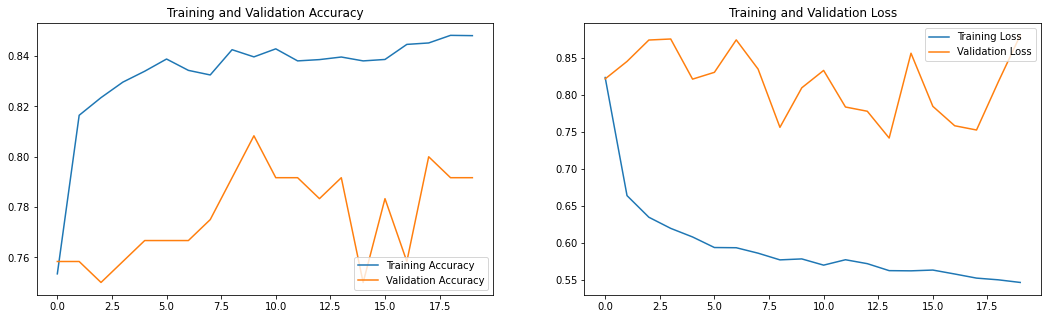

In [136]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [204]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)
next_element = iterator.get_next()
resize_and_rescale(next_element[0])

C:\Anaconda3_64\envs\garden\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


InvalidArgumentError: TypeError: only size-1 arrays can be converted to Python scalars
Traceback (most recent call last):

  File "C:\Anaconda3_64\envs\garden\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "C:\Anaconda3_64\envs\garden\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\manpet\AppData\Local\Temp\ipykernel_30872\1696914425.py", line 24, in load_features
    B02= np.float(B02-ch1_mean)/ch1_std

TypeError: only size-1 arrays can be converted to Python scalars


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [428]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


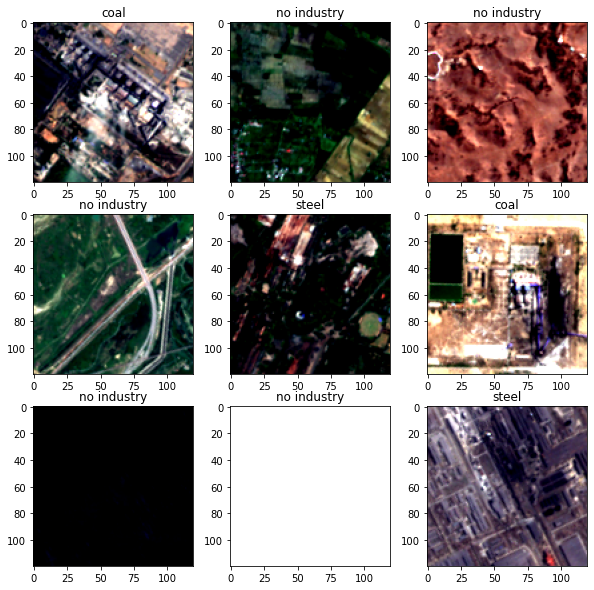

In [361]:
def convert_onehot(next_element):
    if (next_element[1].numpy() == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element[1].numpy() == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element[1].numpy() == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.imshow(np.flip(im[0,:,:,0:3]+0.5, axis=2))
    plt.title(convert_onehot(next_element))

In [345]:
iterator.get_next()

(<tf.Tensor: shape=(1, 230, 230, 4), dtype=float64, numpy=
 array([[[[-0.82846415, -0.9185338 , -0.89272775, -0.51621323],
          [-0.83511912, -0.96313934, -0.93838298, -0.64991697],
          [-0.80754852, -0.89429165, -0.86318613, -0.56292899],
          ...,
          [-0.72768888, -0.7963534 , -0.77187566, -0.35190261],
          [-0.69821687, -0.75368723, -0.71726842, -0.33015561],
          [-0.67539983, -0.76435377, -0.72443003, -0.58145421]],
 
         [[-0.87219681, -0.92435191, -0.92137417, -0.51621323],
          [-0.83511912, -0.9321094 , -0.93480218, -0.51138056],
          [-0.82275988, -0.90010977, -0.88467094, -0.46788658],
          ...,
          [-0.79994284, -0.8710192 , -0.80052208, -0.57903788],
          [-0.71723107, -0.77792937, -0.71637322, -0.45419402],
          [-0.67444912, -0.75950534, -0.69936441, -0.5685671 ]],
 
         [[-0.86934468, -0.95150311, -0.93927818, -0.62253187],
          [-0.84367551, -0.93501845, -0.93032618, -0.51460234],
         

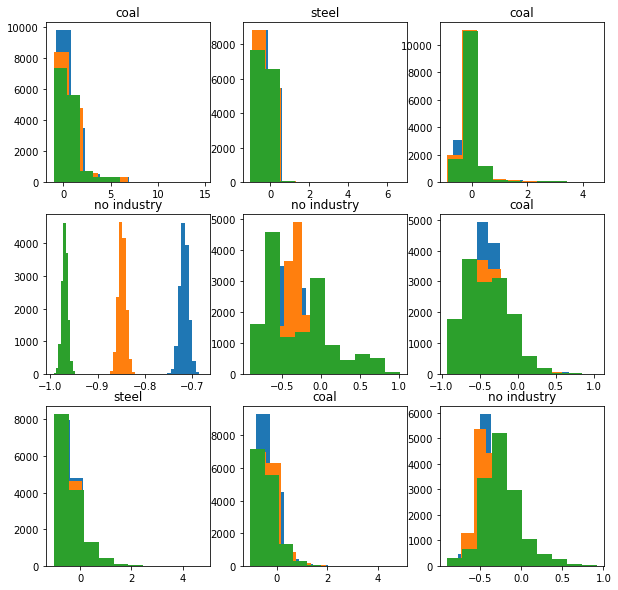

In [348]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.hist(im[0,:,:,0].numpy().reshape(120*120))
    plt.hist(im[0,:,:,1].numpy().reshape(120*120))
    plt.hist(im[0,:,:,2].numpy().reshape(120*120))
    plt.title(convert_onehot(next_element))

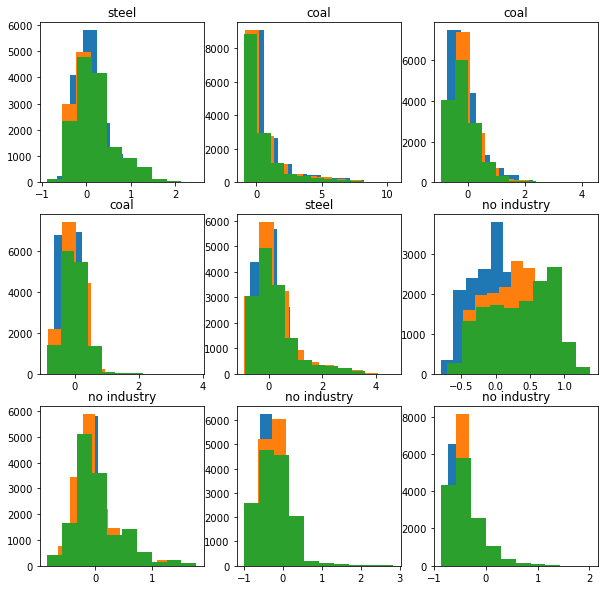

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.hist(im[0,:,:,0].numpy().reshape(120*120))
    plt.hist(im[0,:,:,1].numpy().reshape(120*120))
    plt.hist(im[0,:,:,2].numpy().reshape(120*120))
    plt.title(convert_onehot(next_element))

In [86]:
next_element[0].numpy().reshape(-1)

array([ 195,  338,  296, ...,  305,  259, 2110], dtype=uint16)

-0.04880026311586668
0.09569186261211814
0.33868648778273247
0.27080584931233453


(array([2.0114e+04, 4.7218e+04, 4.7305e+04, 3.1789e+04, 3.0869e+04,
        2.3050e+04, 1.0209e+04, 9.2400e+02, 8.2000e+01, 4.0000e+01]),
 array([ 192. ,  654.4, 1116.8, 1579.2, 2041.6, 2504. , 2966.4, 3428.8,
        3891.2, 4353.6, 4816. ]),
 <BarContainer object of 10 artists>)

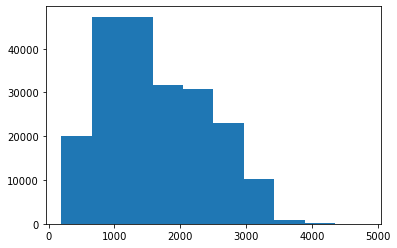

In [139]:
next_element = iterator.get_next()
plt.hist(next_element[0].numpy().reshape(-1))

In [432]:
plt.figure(figsize=(10, 10))
ch1, ch2, ch3, ch4 = np.array([]),np.array([]),np.array([]),np.array([]),
for i in range(100):
    if i%10==0:print(i, '%')
    # ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    ch1 = np.append(ch1, im[0,:,:,0].numpy().reshape(120*120))
    ch2 = np.append(ch2, im[0,:,:,1].numpy().reshape(120*120))
    ch3 = np.append(ch3, im[0,:,:,2].numpy().reshape(120*120))
    ch4 = np.append(ch4, im[0,:,:,3].numpy().reshape(120*120))
    # plt.title(convert_onehot(next_element))

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


<Figure size 720x720 with 0 Axes>

In [433]:
ch1_mean, ch1_std = ch1.mean(), ch1.std()
ch2_mean, ch2_std = ch2.mean(), ch2.std()
ch3_mean, ch3_std = ch3.mean(), ch3.std()
ch4_mean, ch4_std = ch4.mean(), ch4.std()

In [434]:
print(np.round(ch1_mean,3), np.round(ch1_std,3))
print(np.round(ch2_mean,3), np.round(ch2_std,3))
print(np.round(ch3_mean,3), np.round(ch3_std,3))
print(np.round(ch4_mean,3), np.round(ch4_std,3))

1134.44 1224.451
1403.572 1216.386
1554.867 1299.607
2204.596 1166.667


In [141]:
ch1_mean, ch1_std = 970.4162903392252, 1051.8454702994397
ch2_mean, ch2_std = 1176.249944943864, 1031.262597521539
ch3_mean, ch3_std = 1273.2376818390699, 1117.068939085472
ch4_mean, ch4_std = 2266.9050137827385, 1241.5509461215606

In [142]:
ch1_mean, ch1_std = 970.4162903392252, 1051.8454702994397
ch2_mean, ch2_std = 1176.249944943864, 1031.262597521539
ch3_mean, ch3_std = 1273.2376818390699, 1117.068939085472
ch4_mean, ch4_std = 2266.9050137827385, 1241.5509461215606
norm_layer=keras.layers.Normalization(mean=[ch1_mean, ch2_mean, ch3_mean,ch4_mean], variance=[ch1_std**2, ch2_std**2, ch3_std**2, ch4_std**2])